# Introduction to StarDist
### In this notebook, we're going to download the sample data from the StarDist repository, and learn a bit about what is going on in StarDist

#### Please keep in mind, most of these notebooks are cribbed from the StarDist github site

### At the beginning of any Python Program or Jupyter Notebook, we need to import the packages we will use in the notebook.  

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np    # this is the numpy package, it gives us a lot of mathematical functionality
import matplotlib     # this is the plotting package
matplotlib.rcParams["image.interpolation"] = None #this turns off interpolation of images
import matplotlib.pyplot as plt #this renames the plotting package to plt
%matplotlib inline              
%config InlineBackend.figure_format = 'retina'

from glob import glob   #data processing package, that groups data
from tqdm import tqdm   #package that let's us draw status bars
from tifffile import imread #package that allows us to read images
from csbdeep.utils import Path, download_and_extract_zip_file #deep learning package, but specifically parts of it that let us extract zip files

from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap #stardist
from stardist.matching import matching_dataset #stardist

np.random.seed(42)  #makes it so all random numbers are the same , thus called pseduo-random
lbl_cmap = random_label_cmap()

/tmp/slurm_8905904/ipykernel_155401/1663845715.py:4: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None #this turns off interpolation of images


## Data

This notebook demonstrates how the training data for *StarDist* should look like and whether the annotated objects can be appropriately described by star-convex polygons. 

<div class="alert alert-block alert-info">
The training data that needs to be provided for StarDist consists of corresponding pairs of raw images and pixelwise annotated ground truth images (masks), where every pixel has a unique integer value indicating the object id (or 0 for background). 
</div>

For this demo we will download the file `dsb2018.zip` that contains the respective train and test images with associated ground truth labels as used in [our paper](https://arxiv.org/abs/1806.03535).
They are a subset of the `stage1_train` images from the Kaggle 2018 Data Science Bowl, which are [available in full](https://data.broadinstitute.org/bbbc/BBBC038/) from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/).

In [2]:
download_and_extract_zip_file(
    url       = 'https://github.com/stardist/stardist/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files found, nothing to download.


In [9]:
#This code block makes gets the training images and masks
# X = Training Images
# Y = Training masks
X = sorted(glob('data/dsb2018/train/images/*.tif'))
Y = sorted(glob('data/dsb2018/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [10]:
# This code block just grabs a subset of the training images and masks, in order to speed things along
X, Y = X[:10], Y[:10]

In [11]:
# This code block reads in the subset of images as...well, images.
X = list(map(imread,X))
Y = list(map(imread,Y))

# Example image

In [12]:
## Make up list of images and their labels
i = min(4, len(X)-1)
img, lbl = X[i], fill_label_holes(Y[i])  #this line fills holes in labels.  
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

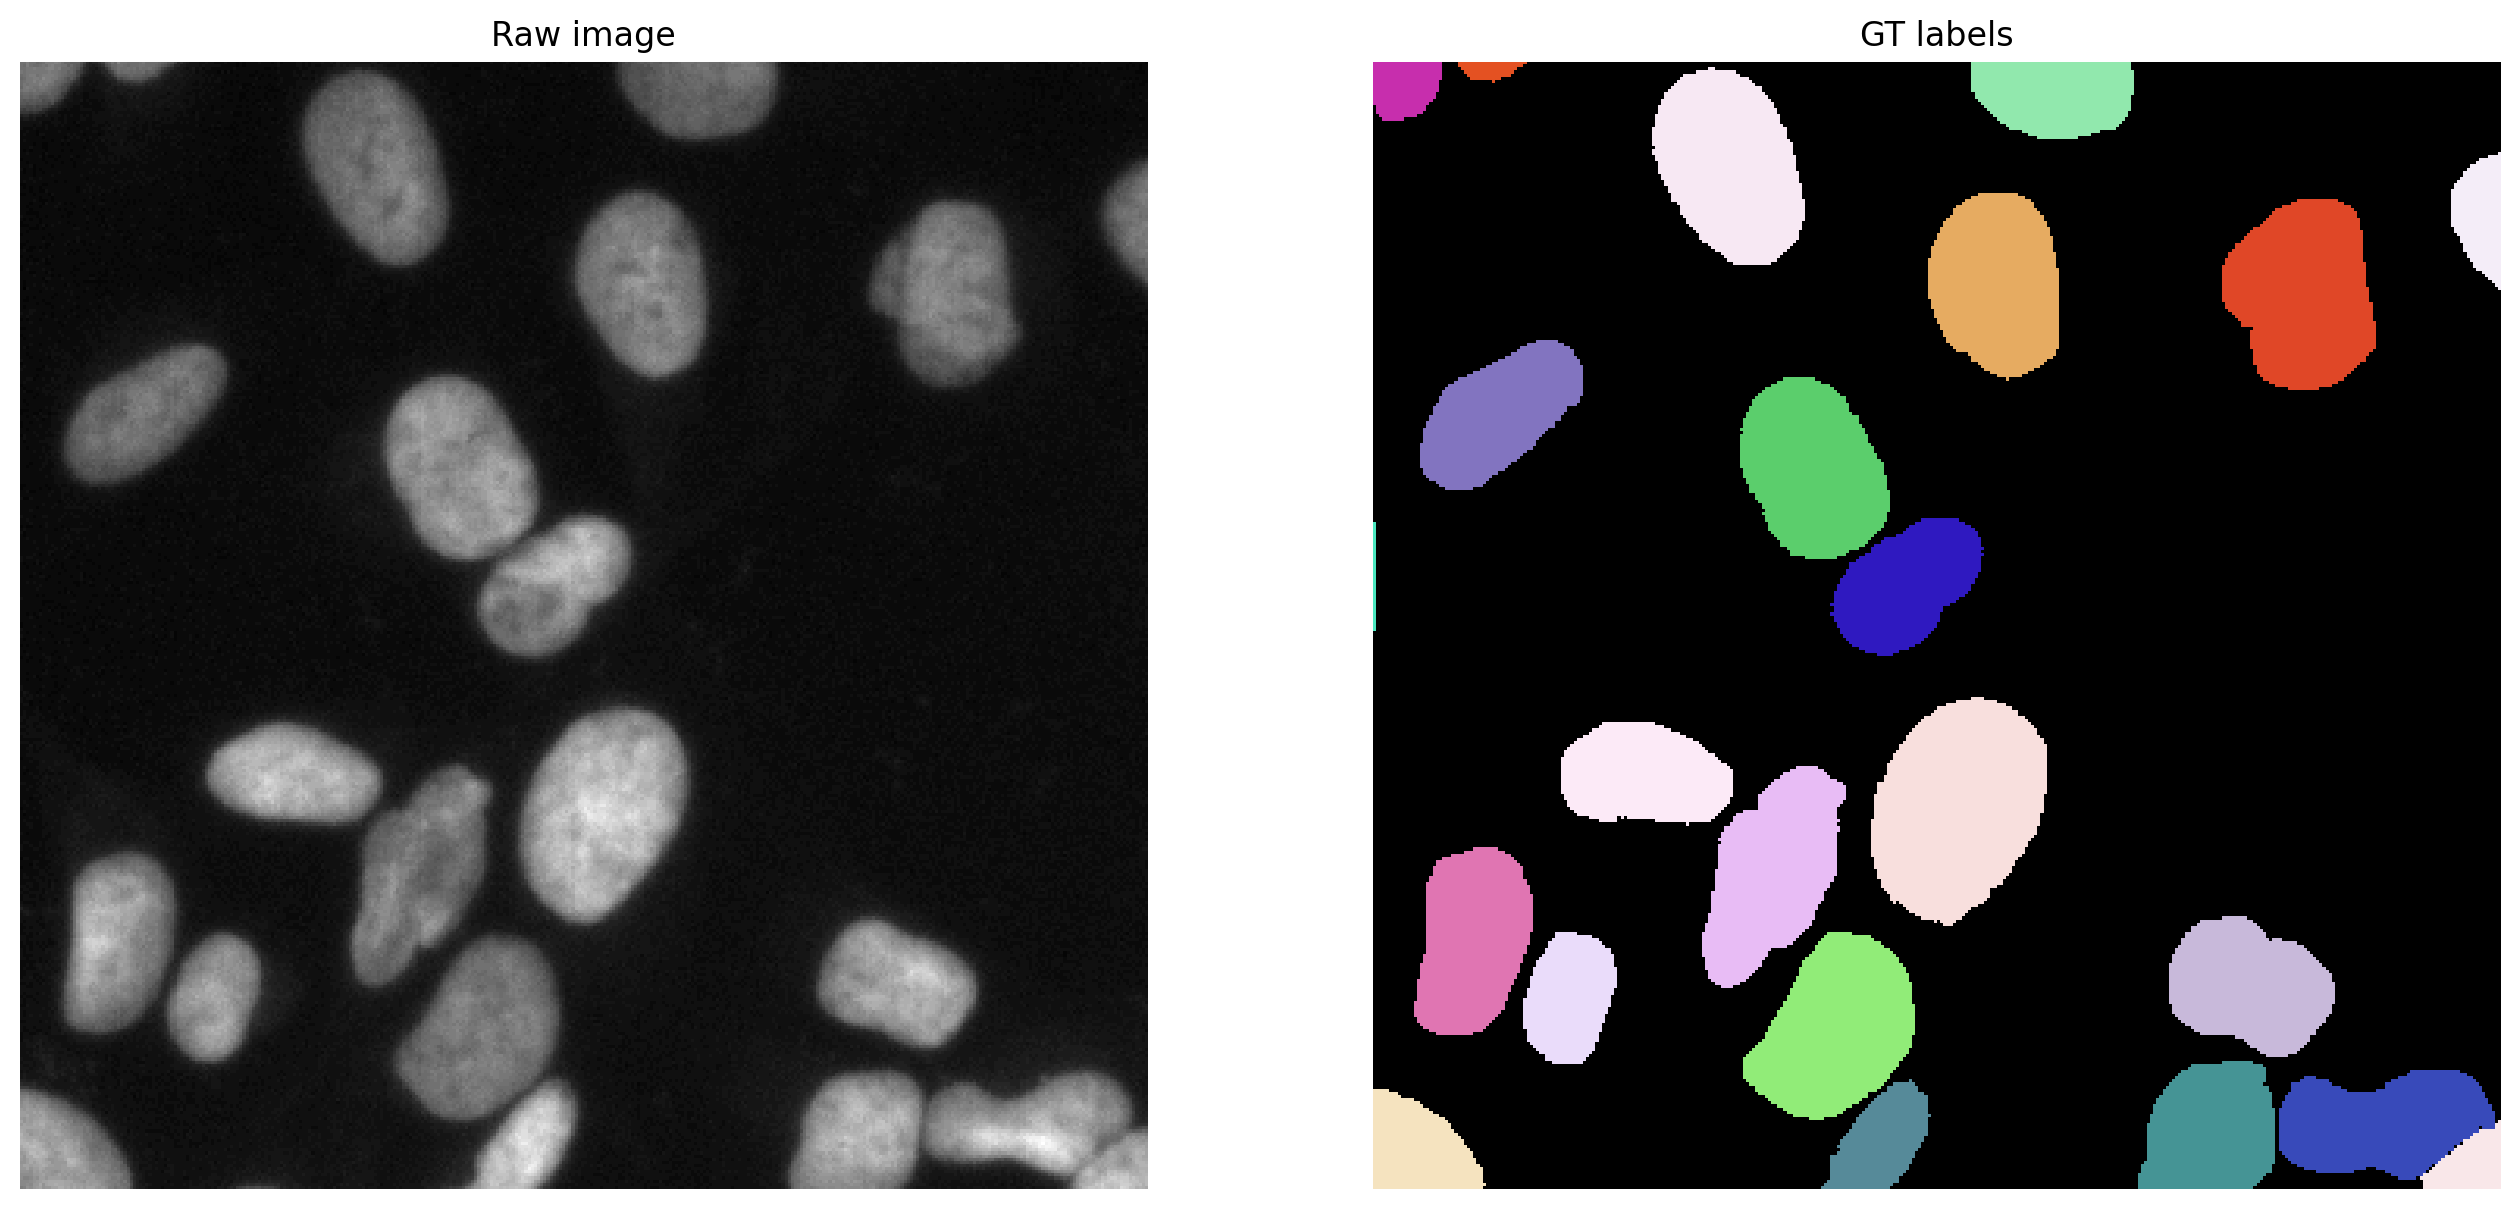

In [13]:
#plot an image and the ground truth labels

plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [14]:
img.shape

(360, 360)

## Take a look at what images and labels look like

### Here we're only plotting the first 5 rows of the image, and then taking a look at the actual numbers in the first row


#### * In the label image:
* The labels will all be integer numbers
* The background will be zero


In [15]:
img_crop = img[0:5]
lbl_crop = lbl[0:5]

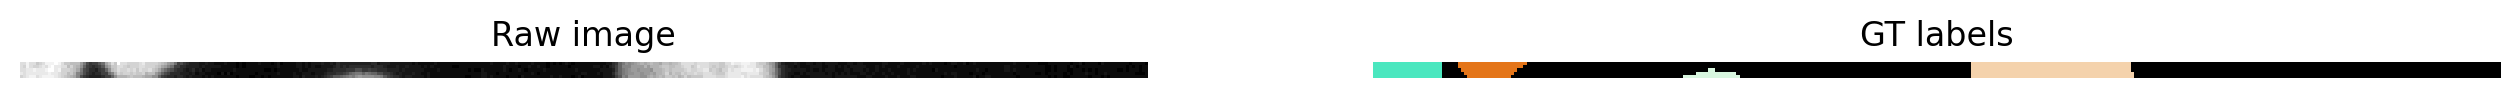

In [16]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img_crop, cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl_crop,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [17]:
img[0]

array([24, 24, 26, 24, 24, 22, 23, 24, 26, 26, 26, 27, 26, 24, 22, 22, 21,
       21, 21, 18, 15, 11,  9, 10, 10, 12, 14, 19, 21, 24, 22, 27, 24, 24,
       23, 23, 23, 23, 24, 25, 23, 23, 23, 23, 22, 21, 20, 18, 17, 14, 10,
       11,  9,  8,  7,  7,  7,  6,  6,  7,  6,  6,  5,  5,  5,  6,  5,  5,
        5,  4,  5,  4,  5,  5,  5,  5,  6,  5,  5,  5,  4,  5,  6,  4,  5,
        5,  5,  5,  6,  6,  5,  6,  5,  6,  6,  6,  7,  6,  6,  7,  6,  8,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  6,  7,  7,  7,  6,
        6,  6,  6,  6,  6,  6,  5,  6,  5,  5,  5,  5,  5,  6,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  5,  5,
        5,  5,  6,  5,  5,  6,  5,  5,  5,  5,  6,  5,  5,  5,  5,  4,  5,
        4,  5,  4,  5,  6,  5,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        6,  6,  8,  9, 13, 15, 17, 16, 17, 18, 19, 20, 19, 20, 21, 20, 20,
       19, 21, 21, 20, 21, 21, 22, 24, 24, 24, 24, 23, 24, 24, 24, 24, 23,
       23, 23, 22, 22, 24

In [18]:
lbl[0]

array([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22,  0,  0,  0,  0,  0,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3